# Part 2: Time Series Modeling

In this notebook, you will implement functions to extract features from time series data and build ARIMA models.

In [4]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pathlib import Path
import os

# Set style for plots
sns.set_theme()
%matplotlib inline

## 1. Feature Extraction

Implement the `extract_time_series_features` function to calculate rolling window features.

In [5]:
# Load preprocessed combined dataset
processed_data = pd.read_csv(
    '/workspaces/4-it-s-about-time-anagasuri/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data/Processed/all_subjects_combined.csv',
    parse_dates=['timestamp']  # Ensures timestamp is parsed as datetime
)

def extract_time_series_features(data, window_size=60):
    """Extract rolling window features from time series data.
    
    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data with a 'timestamp' column
    window_size : int
        Size of the rolling window in seconds
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing extracted features for each signal
    """
    # Ensure timestamp is datetime index
    if 'timestamp' in data.columns:
        data = data.set_index('timestamp')

    features = []

    # Group by subject and session
    for (subject, session), group in data.groupby(['subject_id', 'session']):
        df = group.sort_index()
        numeric_cols = df.select_dtypes(include='number').columns

        feature_df = pd.DataFrame(index=df.index)

        for col in numeric_cols:
            roll = df[col].rolling(window=window_size, min_periods=window_size)
            feature_df[f'{col}_mean'] = roll.mean()
            feature_df[f'{col}_std'] = roll.std()
            feature_df[f'{col}_min'] = roll.min()
            feature_df[f'{col}_max'] = roll.max()
            feature_df[f'{col}_autocorr'] = roll.apply(lambda x: x.autocorr(lag=1), raw=False)

        feature_df['subject_id'] = subject
        feature_df['session'] = session
        features.append(feature_df)

    return pd.concat(features).dropna().reset_index()


In [14]:
features_df = extract_time_series_features(processed_data, window_size=60)
print(features_df.head())

                  timestamp  heart_rate_mean  heart_rate_std  heart_rate_min  \
0 2018-12-05 16:30:06+00:00       120.990333       12.184715           82.50   
1 2018-12-05 16:30:07+00:00       121.242333       12.236002           82.50   
2 2018-12-05 16:30:08+00:00       122.072667       11.209745           86.25   
3 2018-12-05 16:30:09+00:00       122.670833       10.761403           86.25   
4 2018-12-05 16:30:10+00:00       123.453667        9.725641           98.60   

   heart_rate_max  heart_rate_autocorr  eda_mean   eda_std   eda_min  \
0          132.19             0.895452  0.023592  0.000448  0.022744   
1          132.19             0.962682  0.023598  0.000452  0.022744   
2          132.32             0.966036  0.023608  0.000454  0.022744   
3          132.32             0.974671  0.023608  0.000454  0.022744   
4          133.22             0.978590  0.023614  0.000449  0.022744   

    eda_max  eda_autocorr  temperature_mean  temperature_std  temperature_min  \
0  0.

## 2. ARIMA Modeling

Implement the `build_arima_model` function to fit ARIMA models and generate diagnostic plots.

In [8]:
def build_arima_model(series, order=(1,1,1), output_dir='/workspaces/4-it-s-about-time-anagasuri/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data/plots', label="series"):
    
    """Fit an ARIMA model to the time series and generate diagnostic plots.
    
    Parameters
    ----------
    series : pd.Series
        Time series data to model
    order : tuple
        (p,d,q) order of the ARIMA model
    output_dir : str
        Directory to save diagnostic plots
        
    Returns
    -------
    statsmodels.tsa.arima.model.ARIMAResults
        Fitted ARIMA model
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Your code here
    # 1. Fit ARIMA model
    # 2. Generate diagnostic plots:
    #    - Model fit plot
    #    - Residuals plot
    #    - Forecast plot
    # 3. Save plots to output directory
    
    model = ARIMA(series, order=order)
    results = model.fit()

    # Plot 1: Fitted vs Actual
    plt.figure(figsize=(12, 4))
    plt.plot(series, label='Observed')
    plt.plot(results.fittedvalues, label='Fitted', linestyle='--')
    plt.title(f'ARIMA Fit - {label}')
    plt.legend()
    plt.tight_layout()
    fit_path = os.path.join(output_dir, f'{label}_arima_fit.png')
    plt.savefig(fit_path)
    plt.close()

    # Plot 2: Residuals
    plt.figure(figsize=(12, 4))
    plt.plot(results.resid)
    plt.title(f'ARIMA Residuals - {label}')
    plt.tight_layout()
    resid_path = os.path.join(output_dir, f'{label}_arima_residuals.png')
    plt.savefig(resid_path)
    plt.show() 
    plt.close()

    print(f"Saved: {fit_path} and {resid_path}")
    return results


/home/codespace/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency s will be used.
  self._init_dates(dates, freq)
/home/codespace/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency s will be used.
  self._init_dates(dates, freq)
/home/codespace/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency s will be used.
  self._init_dates(dates, freq)


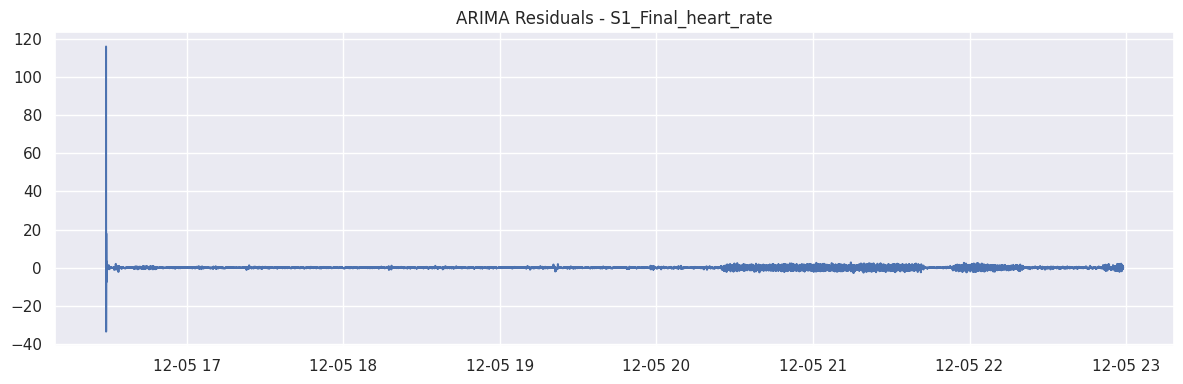

Saved: plots/S1_Final_heart_rate_arima_fit.png and plots/S1_Final_heart_rate_arima_residuals.png


In [9]:
series = processed_data[
    (processed_data['subject_id'] == 'S1') &
    (processed_data['session'] == 'Final')
].set_index('timestamp')['heart_rate']

model = build_arima_model(series, order=(1, 1, 1), output_dir='plots', label='S1_Final_heart_rate')
